In [2]:
import cebra
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsClassifier
from utils import TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Load

In [3]:
df = pd.read_hdf("data/ID18150/Day2/DataFrame_Imaging_dFF_18150_day2.h5")
# Get a list of columns whose names are of numerical type
numerical_columns = [col for col in df.columns if type(col) == int]

#Feature matrix
X = df[numerical_columns].values
t = df.Time.to_list()

In [4]:
delta = 5000
def get_x_ticks(L:int):
    x_ticks = np.arange(0,L,delta)
    x_tick_labels = [f"{t[i]/100:.2f}" for i in x_ticks]
    return x_ticks, x_tick_labels

In [5]:
split = int(0.2*len(X))
X_train, X_test = X[:-split], X[-split:]
y_train, y_test = df["Pump"].values[:-split], df["Pump"].values[-split:]
X_train.shape, X_test.shape

((52796, 709), (13198, 709))

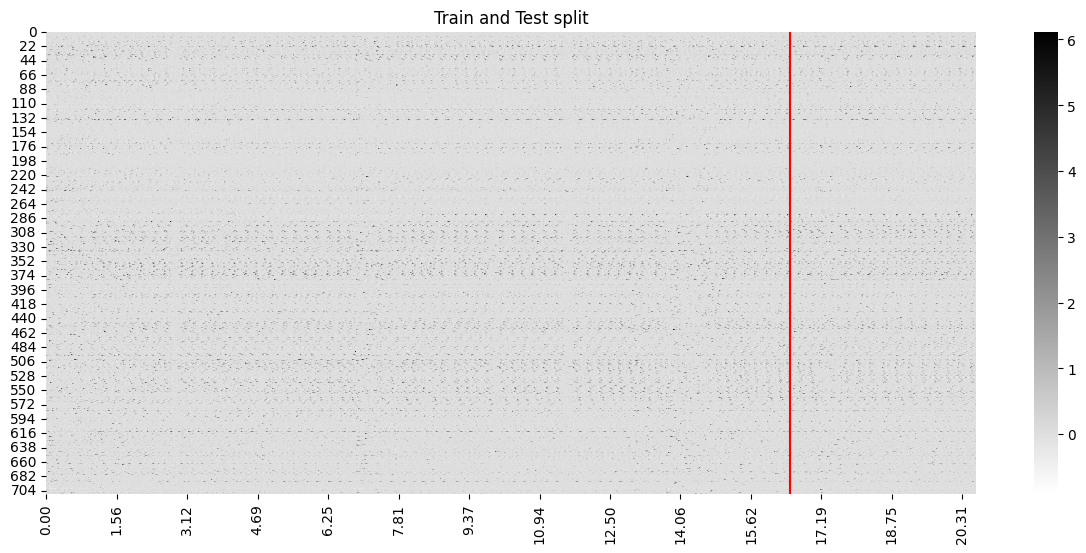

In [6]:
x_ticks, x_tick_labels = get_x_ticks(X.shape[0])
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax = sns.heatmap(X.T, ax=ax, cmap="gray_r")
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels)

v_bar = X_train.shape[0]
ax.axvline(v_bar, color="red")

ax.set_title("Train and Test split")

plt.show()

# CEBRA Encoder

## Dataset Preparation

In [7]:
with device:
    train = TensorDataset(
        neural = torch.from_numpy(X_train).type(torch.FloatTensor),
        discrete = torch.from_numpy(y_train).type(torch.LongTensor),
        offset = cebra.data.Offset(1) #It doesn't matter what you put here, it gets updated later
    )
    test = TensorDataset(
        neural = torch.from_numpy(X_test).type(torch.FloatTensor),
        discrete = torch.from_numpy(y_test).type(torch.LongTensor),
        offset = cebra.data.Offset(1)
    )

# Models

In [8]:
cebra.data.TensorDataset.__init__

class ModelPipeline:
    def __init__(self, model_name, train_dataset, test_dataset, num_units, latent_dimension = 8):
        self.model_name = model_name
        self.latent_dimension = latent_dimension
        self.num_units = num_units
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        with device:
            self.model = cebra.models.init(
                name = model_name,
                num_neurons = train_dataset.neural.shape[1],
                num_units = num_units,
                num_output = latent_dimension
            )
            self.train_dataset.configure_for(self.model)
            self.test_dataset.configure_for(self.model)
    def train_embedding(self, learning_rate, batch_size, steps = 1000):
        self.batch_size = batch_size
        self.steps = steps
        with device:
            criterion = cebra.models.criterions.LearnableCosineInfoNCE()
            optimizer = torch.optim.Adam(
                list(self.model.parameters()) + list(criterion.parameters()),
                lr = learning_rate
            )
            self.solver = cebra.solver.SingleSessionSolver(
                model = self.model,
                criterion = criterion,
                optimizer = optimizer,
                tqdm_on = True
            )
            train_loader = cebra.data.single_session.DiscreteDataLoader(
                dataset = train,
                num_steps = steps,
                batch_size = batch_size,
                prior = "empirical"
            )
            self.solver.fit(loader=train_loader)
    def train_decoder(self, n_neighbors):
        U_train = self.get_embedding(self.train_dataset.neural).detach().cpu().numpy()
        y_train = self.train_dataset.discrete.cpu().numpy()
        self.decoder = KNeighborsClassifier(n_neighbors=n_neighbors)
        self.decoder.fit(U_train, y_train)
    def train(self, learning_rate, batch_size, steps, n_neighbors):
        self.train_embedding(learning_rate, batch_size, steps)
        self.train_decoder(n_neighbors)
    def get_embedding(self, X, device = torch.device("cpu")):
        with device:
            if type(X) == np.ndarray:
                X = torch.from_numpy(X)
            dataset = TensorDataset(
                neural = X.to(device),
                offset = self.model.get_offset(),
                device = device
            )
            dataset.configure_for(self.model)
            ix = torch.arange(len(dataset))
            X_offset = dataset[ix]
            return self.model(X_offset)
    def score(self, verbose = True):
        test_loader = cebra.data.single_session.DiscreteDataLoader(
            dataset = test,
            num_steps = self.steps,
            batch_size = self.batch_size,
            prior = "empirical"
        )
        self.embedding_score = self.solver.validation(test_loader)
        U_test = self.get_embedding(self.test_dataset.neural).detach().cpu().numpy()
        y_test = self.test_dataset.discrete.cpu().numpy()
        self.decoder_score = 1 - self.decoder.score(U_test, y_test)
        try:
            # Fit an exponential decay to the history and get the R2 value
            def exp_decay(x, a, b, c):
                return a * np.exp(-b * x) + c

            # Fit the exponential decay to the solver history
            x_data = np.arange(len(self.solver.history))
            y_data = self.solver.history
            y0 = y_data[0]
            yf = y_data[-1]
            popt, _ = curve_fit(exp_decay, x_data, y_data, p0=(y0 - yf, 1e-6, yf))

            # Calculate the R2 value
            y_pred = exp_decay(x_data, *popt)
            r2 = r2_score(y_data, y_pred)
            if verbose:
                print(f"Expontial decay R2: {r2}, embedding score: {self.embedding_score}, decoder score: {self.decoder_score}")
            return -r2 + self.embedding_score + 2*self.decoder_score
        except:
            return float("inf")
        

In [9]:
models_to_try = list(filter(lambda x: "offset" == x[:6] and not "mse" == x[-3:] and not "subsample" == x[-9:],cebra.models.get_options()))
models_to_try

['offset10-model',
 'offset5-model',
 'offset1-model',
 'offset1-model-v2',
 'offset1-model-v3',
 'offset1-model-v4',
 'offset1-model-v5',
 'offset36-model',
 'offset36-model-dropout',
 'offset36-model-more-dropout']

In [10]:
def experiment(trial):
    model_name = trial.suggest_categorical("model_name", models_to_try)
    num_units = trial.suggest_int("num_units", 1, X_train.shape[1])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_int("batch_size", 50, 512, log=True)
    n_neighbors = trial.suggest_int("n_neighbors", 1, 50)
    model = ModelPipeline(model_name, train, test, num_units)
    model.train(learning_rate, batch_size, 500, n_neighbors)
    score = model.score()
    
    # Save the best model to disk
    if not hasattr(experiment, "best_score") or score < experiment.best_score:
        experiment.best_score = score
        experiment.pipeline = model
        torch.save(model.model.state_dict(), "./data/models/best_model.pth")
    
    return score

In [11]:
study = optuna.create_study(storage="sqlite:///data/ID18150/Day2/offsets.db", study_name="cebra_offsets", direction="minimize", load_if_exists=True)
study.optimize(experiment, n_trials=100)

study.best_params

[I 2024-10-20 00:10:07,681] Using an existing study with name 'cebra_offsets' instead of creating a new one.
pos: -0.9833 neg:  5.1736 total:  4.1904 temperature:  1.0002: 100%|██████████| 1/1 [00:00<00:00,  4.96it/s]
/home/icaro/Documents/doctorate/dimensionality-reduction/utils.py:78: UserWarning: You should pass at least one of the arguments 'continuous' or 'discrete'.
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 83.13it/s]
/home/icaro/Documents/doctorate/dimensionality-reduction/utils.py:78: UserWarning: You should pass at least one of the arguments 'continuous' or 'discrete'.
  warnings.warn(
[I 2024-10-20 00:10:10,787] Trial 59 finished with value: inf and parameters: {'model_name': 'offset1-model-v5', 'num_units': 155, 'learning_rate': 0.00020420246183909557, 'batch_size': 66, 'n_neighbors': 15}. Best is trial 59 with value: inf.
pos: -0.9889 neg:  7.2252 total:  6.2363 temperature:  0.9991: 100%|██████████| 1/1 [00:00<00:00, 16.74it/s]
/home/icaro/Documents/doctorate/dim

KeyboardInterrupt: 